<a href="https://colab.research.google.com/github/adamhb/Earth-System-Model-Tools/blob/master/FATES_emulation_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import data

In [1]:
from google.colab import files
uploaded = files.upload() #import the labeled remote sensing data

Saving all_member_output_101223.csv to all_member_output_101223.csv


## Functions

In [14]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

from sklearn.metrics import confusion_matrix
import pandas as pd

def labeled_confusion_matrix(y_true, y_pred, labels=[0, 1], label_names=None):
    """
    Returns a labeled confusion matrix using pandas DataFrame.

    Args:
    - y_true: list or array-like, Ground truth target values.
    - y_pred: list or array-like, Estimated target values.
    - labels: list, The set of labels to include in the confusion matrix.
    - label_names: list or None, Names of the labels for better visualization.

    Returns:
    - DataFrame of the confusion matrix.
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Check if custom label names are provided
    if label_names:
        labels = label_names

    # Convert the matrix to a DataFrame for better labeling
    df_cm = pd.DataFrame(
        cm,
        columns=[f'Predicted {label}' for label in labels],
        index=[f'Actual {label}' for label in labels]
    )
    return df_cm


## Import and clean data

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
import io
import numpy as np

raw_df = pd.read_csv(io.StringIO(uploaded['all_member_output_101223.csv'].decode('utf-8')),sep = ',')

print(raw_df.info())
print("\n")

# Drop first column
raw_df.drop(columns=raw_df.columns[0], axis=1, inplace=True)
print(list(raw_df.columns))

df = raw_df.copy()

df.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Columns: 117 entries, Unnamed: 0 to case_tag
dtypes: float64(113), int64(4)
memory usage: 2.7 MB
None


['BA', 'AGB', 'TreeStemD', 'ResproutD_oak', 'ResproutD_shrub', 'ShannonE', 'NPP', 'FailedPFTs', 'Pct_shrub_cover_canopy', 'Pct_shrub_cover', 'Combustible_fuel', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_shrub', 'BA_oak', 'inst', 'fates_recruit_seed_alloc_mature_1', 'fates_recruit_seed_alloc_mature_2', 'fates_recruit_seed_alloc_mature_3', 'fates_recruit_seed_alloc_mature_4', 'fates_recruit_seed_alloc_mature_5', 'fates_recruit_seed_dbh_repro_threshold_1', 'fates_recruit_seed_dbh_repro_threshold_2', 'fates_recruit_seed_dbh_repro_threshold_3', 'fates_recruit_seed_dbh_repro_threshold_5', 'fates_fire_alpha_SH_1', 'fates_fire_alpha_SH_2', 'fates_fire_alpha_SH_3', 'fates_fire_alpha_SH_4', 'fates_fire_alpha_SH_5', 'fates_fire_bark_scaler_1', 'fates_fire_bark_scaler_2', 'fates_fire_bark_scaler_3', 'fates_fire_bark_scaler_4', 

Add coexistence variable

In [5]:
df['coexistence'] = df['FailedPFTs'] == 0
coex_table = df['coexistence'].value_counts()

print("\n")

print('Coexistence success rate:',coex_table[1]/coex_table[0] * 100, "%")



Coexistence success rate: 6.403940886699508 %


## Split data into train and test sets

While ensuring that the train and test sets have equal ratios of coexistence to non-coexistence

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['coexistence']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_coex = train_set["coexistence"].copy()
train_y_shannonE = train_set["ShannonE"].copy()
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_y_coex = test_set["coexistence"].copy()
test_y_shannonE = test_set["ShannonE"].copy()
test_y_failedPFTs = test_set["FailedPFTs"].copy()

In [7]:
print("train:",train_y_coex.value_counts())
print("test:",test_set['coexistence'].value_counts())

train: False    2557
True      164
Name: coexistence, dtype: int64
test: False    285
True      18
Name: coexistence, dtype: int64


## Set up a data transformation pipeline to prepare the data for machine learning

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# This is for if I need to define a custom data transformation function
from sklearn.base import BaseEstimator, TransformerMixin

# Data transformation pipeline
transformation_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # Scale the data by substracting mean and dividing by sigma
    ])

# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)

# Apply to test data

X_test = transformation_pipeline.fit_transform(test_X)

## Define a naive classifier to compare our classifiers to

This classifier always predicts no coexistence.

In [8]:
from sklearn.base import BaseEstimator
class NeverCoexist(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):

        #always predicts false (0)
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
# Naive classifier
never_coexist = NeverCoexist()
# test naive classifier
naive_scores = cross_val_score(never_coexist, X, train_y_coex, cv= 10, scoring="accuracy")
print("Naive:",display_scores(naive_scores))

Scores: [0.91941392 0.97058824 0.94485294 0.92279412 0.91544118 0.94485294
 0.95220588 0.94852941 0.91911765 0.95955882]
Mean: 0.9397355095884506
Standard deviation: 0.018290331458515947
Naive: None


## Build and train a deep neural network

In [24]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Sample data (replace this with your data)
# Let's assume each data point has 8 features for this example.
X_train = X
y_train = train_y_coex
X_test = X_test
y_test = test_y_coex

# Build the model
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu')) # input_dim should match the number of features in your dataset
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Save the model if needed
# model.save("binary_classifier.h5")

Epoch 1/10
86/86 [==============================] - 4s 12ms/step - loss: 0.4172 - accuracy: 0.8361 - val_loss: 0.2474 - val_accuracy: 0.9406
Epoch 2/10
86/86 [==============================] - 0s 4ms/step - loss: 0.2274 - accuracy: 0.9397 - val_loss: 0.2353 - val_accuracy: 0.9406
Epoch 3/10
86/86 [==============================] - 0s 5ms/step - loss: 0.2117 - accuracy: 0.9397 - val_loss: 0.2304 - val_accuracy: 0.9406
Epoch 4/10
86/86 [==============================] - 0s 5ms/step - loss: 0.1998 - accuracy: 0.9397 - val_loss: 0.2268 - val_accuracy: 0.9406
Epoch 5/10
86/86 [==============================] - 0s 4ms/step - loss: 0.1902 - accuracy: 0.9397 - val_loss: 0.2255 - val_accuracy: 0.9406
Epoch 6/10
86/86 [==============================] - 0s 2ms/step - loss: 0.1819 - accuracy: 0.9405 - val_loss: 0.2214 - val_accuracy: 0.9406
Epoch 7/10
86/86 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.9405 - val_loss: 0.2218 - val_accuracy: 0.9406
Epoch 8/10
86/86 [=

## Display training and validation accuracy (using the test partition for validation) during training

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


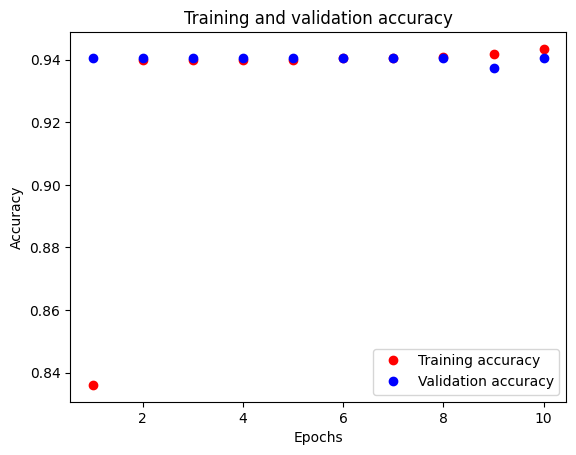

In [36]:
history_dict = history.history
print(history_dict.keys())
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
val_loss = history_dict['val_loss']


epochs = range(1,len(val_acc) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs,train_acc, 'ro',label='Training accuracy')
plt.plot(epochs, val_acc, 'bo',label = "Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## View confusion matrix for predictions on the test data

10/10 [==============================] - 0s 3ms/step


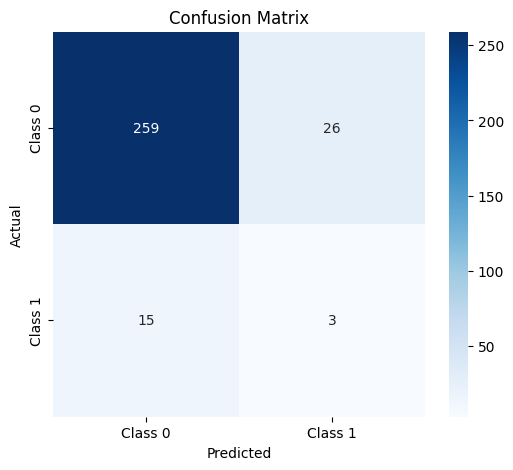

              precision    recall  f1-score   support

     Class 0       0.95      0.91      0.93       285
     Class 1       0.10      0.17      0.13        18

    accuracy                           0.86       303
   macro avg       0.52      0.54      0.53       303
weighted avg       0.90      0.86      0.88       303



In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes (instead of probabilities) for the test set
y_pred = model.predict(X_test)

y_pred_boolean = y_pred > 0.15

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_boolean)

# Display the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Optionally, display the classification report for more detailed metrics
print(classification_report(y_test, y_pred_boolean, target_names=['Class 0', 'Class 1']))


# Scratch below

In [ ]:
from keras import models
from keras import layers


model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape = (6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Compile Model

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/50
12/12 [==============================] - 13s 45ms/step - loss: 0.6587 - acc: 0.4043 - val_loss: 0.6373 - val_acc: 0.5800
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6356 - acc: 0.6771 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.5956 - acc: 0.7871 - val_loss: 0.5892 - val_acc: 0.7520
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.5745 - acc: 0.7964 - val_loss: 0.5682 - val_acc: 0.7720
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.5562 - acc: 0.8125 - val_loss: 0.5488 - val_acc: 0.7780
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.5239 - acc: 0.8305 - val_loss: 0.5291 - val_acc: 0.7960
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.5105 - acc: 0.8460 - val_loss: 0.5095 - val_acc: 0.8040
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.4911 - acc: 0.

Analyze model fitting

In [ ]:
history_dict = history.history
print(history_dict.keys())
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']
val_loss = history_dict['val_loss']

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


Plot model fitting process

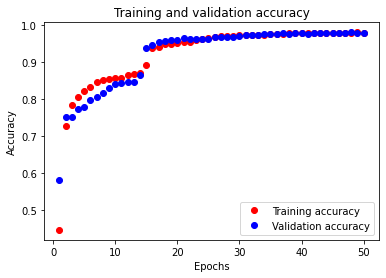

In [ ]:
epochs = range(1,len(val_acc) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs,train_acc, 'ro',label='Training accuracy')
plt.plot(epochs, val_acc, 'bo',label = "Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Rebuilding the model on all training data with tuned hyperparameters (i.e. 50 epochs)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape = (6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(train_x,train_y,
          epochs=50,batch_size=128,verbose=0)

In [ ]:
model.evaluate(test_x,test_y)
model.predict(test_x).shape

24/24 [==============================] - 0s 1ms/step - loss: 0.0601 - acc: 0.9772


(744, 1)

The test accuracy for identifying conifer forest vs. other vegetation is ~ 98%

Save the model to google cloud storage platform

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=AuEOduI9JWVr27oKwPS-CagjUYc7h0RLp0tYZ_lRRNk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4V3t8EitH063iAwjQ6f4RfIt3dh0tKQSZWmUprisBOYv7NXxRhQA8

Successfully saved authorization token.


In [ ]:
OUTPUT_BUCKET = 'postfire-regen-01'
MODEL_DIR = 'gs://' + OUTPUT_BUCKET + '/conifer_classifier'
model.save(MODEL_DIR, save_format='tf')


INFO:tensorflow:Assets written to: gs://postfire-regen-01/conifer_classifier/assets


EarthEngine-ify the model

In [ ]:

from tensorflow.python.tools import saved_model_utils

PROJECT = 'postfire-regen'

meta_graph_def = saved_model_utils.get_meta_graph_def(MODEL_DIR, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "ConProb"}) + "'"
print(input_dict)
print(output_dict)

'{"serving_default_dense_3_input:0": "array"}'
'{"StatefulPartitionedCall:0": "ConProb"}'


In [ ]:
#!pip install -U earthengine-api --no-deps

Requirement already up-to-date: earthengine-api in /usr/local/lib/python3.7/dist-packages (0.1.267)


In [ ]:
# Put the EEified model next to the trained model directory in google storage
EEIFIED_DIR = 'gs://' + OUTPUT_BUCKET + '/eeified_conifer_classifier'


# You need to set the project before using the model prepare command.
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {MODEL_DIR} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

Instructions for updating:
non-resource variables are not supported in the long term
Successfully saved project id
Instructions for updating:
non-resource variables are not supported in the long term
Success: model at 'gs://postfire-regen-01/eeified_conifer_classifier' is ready to be hosted in AI Platform.


Host the model in Google AI platform

In [ ]:
MODEL_NAME = 'eeified_conifer_classifier'
REGION = 'us-central1'
VERSION_NAME = 'v0'

!gcloud ai-platform models create {MODEL_NAME} \
  --project 'postfire-regen' \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --region {REGION} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version=2.3 \
  --python-version=3.7

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/postfire-regen/models/eeified_conifer_classifier].


To take a quick anonymous survey, run:
  $ gcloud survey

Using endpoint [https://us-central1-ml.googleapis.com/]
